In [ ]:
!pip -q install transformers datasets sacrebleu sentencepiece accelerate evaluate

from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/nlp_final"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
Mounted at /content/drive


## 📊 DATA – Load & thống kê


In [ ]:
from datasets import load_dataset, DatasetDict

SEED = 42

# 1) Load opus100 En–Vi
ds_raw = load_dataset("opus100", "en-vi")
print(ds_raw)

# 2) Giảm size cho nhẹ (bạn có thể tăng số nếu GPU chịu được)
train_small = ds_raw["train"].shuffle(SEED).select(range(20000))    # 20k câu train
valid_small = ds_raw["validation"].shuffle(SEED).select(range(1000)) # 1k câu valid
test_small  = ds_raw["test"].shuffle(SEED).select(range(1000))       # 1k câu test

ds = DatasetDict({
    "train": train_small,
    "validation": valid_small,
    "test": test_small,
})

print(ds)
print(ds["train"][0])  # thử xem 1 mẫu => {'translation': {'en': '...', 'vi': '...'}}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-vi/test-00000-of-00001.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

en-vi/train-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

en-vi/validation-00000-of-00001.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1000
    })
})
{'translation': {'en': "He's looking right at us. Don't worry.", 'vi': 'Không sao cả, nó sẽ học sự sợ hãi.'}}


## 🧠 MODEL – MarianMT
### Load MarianMT EN–VI
Model: Helsinki-NLP/opus-mt-en-vi


In [ ]:
import torch
from transformers import MarianMTModel, MarianTokenizer, DataCollatorForSeq2Seq

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model_name_en_vi = "Helsinki-NLP/opus-mt-en-vi"

tok_en_vi = MarianTokenizer.from_pretrained(model_name_en_vi)
model_en_vi = MarianMTModel.from_pretrained(model_name_en_vi).to(device)

Device: cuda


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/756k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/289M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]


### Load MarianMT VI→EN


In [ ]:
model_name_vi_en = "Helsinki-NLP/opus-mt-vi-en"

tok_vi_en = MarianTokenizer.from_pretrained(model_name_vi_en)
model_vi_en = MarianMTModel.from_pretrained(model_name_vi_en).to(device)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/756k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/289M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

### Tiền xử lý & mã hoá VI→EN


In [ ]:
def preprocess_vi_en(batch):
    # nguồn: Vietnamese, đích: English
    src_texts = [ex["vi"] for ex in batch["translation"]]
    tgt_texts = [ex["en"] for ex in batch["translation"]]

    model_inputs = tok_vi_en(
        src_texts,
        max_length=max_source_length,
        truncation=True,
        padding="max_length",
    )

    with tok_vi_en.as_target_tokenizer():
        labels = tok_vi_en(
            tgt_texts,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_vi_en = ds.map(
    preprocess_vi_en,
    batched=True,
    remove_columns=ds["train"].column_names,
)

data_collator_vi_en = DataCollatorForSeq2Seq(
    tokenizer=tok_vi_en,
    model=model_vi_en,
    padding="longest",
)

model.safetensors:   0%|          | 0.00/289M [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Tiền xử lý + tạo encoded dataset cho model

In [ ]:
from transformers import DataCollatorForSeq2Seq

max_source_length = 128
max_target_length = 128

def preprocess_en_vi(batch):
    # lấy English làm nguồn, Vietnamese làm đích
    src_texts = [ex["en"] for ex in batch["translation"]]
    tgt_texts = [ex["vi"] for ex in batch["translation"]]

    model_inputs = tok_en_vi(
        src_texts,
        max_length=max_source_length,
        truncation=True,
        padding="max_length",
    )

    with tok_en_vi.as_target_tokenizer():
        labels = tok_en_vi(
            tgt_texts,
            max_length=max_target_length,
            truncation=True,
            padding="max_length",
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# ✅ Áp dụng tiền xử lý
encoded_en_vi = ds.map(
    preprocess_en_vi,
    batched=True,
    remove_columns=ds["train"].column_names,  # bỏ cột 'translation'
)

data_collator_en_vi = DataCollatorForSeq2Seq(
    tokenizer=tok_en_vi,
    model=model_en_vi,
    padding="longest",
)

# 🔍 In thử 1–2 mẫu TRƯỚC & SAU tiền xử lý
print("📌 Mẫu thô (raw) từ ds['train'][0]:")
print(ds["train"][0]["translation"])
print("-" * 60)

print("📌 Mẫu SAU TIỀN XỬ LÝ (encoded_en_vi['train'][0]):")
sample_enc = encoded_en_vi["train"][0]
print({k: v[:20] for k, v in sample_enc.items()})  # in 20 token đầu cho gọn
print("-" * 60)

# 🔍 Decode lại để kiểm tra
input_ids  = sample_enc["input_ids"]
label_ids  = sample_enc["labels"]

src_decoded = tok_en_vi.decode(input_ids, skip_special_tokens=True)
tgt_decoded = tok_en_vi.decode(
    [tid for tid in label_ids if tid != -100],  # bỏ -100 nếu có
    skip_special_tokens=True
)

print("🔁 Decode lại input_ids  →", src_decoded)
print("🔁 Decode lại labels     →", tgt_decoded)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


model.safetensors:   0%|          | 0.00/289M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

📌 Mẫu thô (raw) từ ds['train'][0]:
{'en': "He's looking right at us. Don't worry.", 'vi': 'Không sao cả, nó sẽ học sự sợ hãi.'}
------------------------------------------------------------
📌 Mẫu SAU TIỀN XỬ LÝ (encoded_en_vi['train'][0]):
{'input_ids': [149, 8, 11, 1049, 175, 135, 170, 2, 495, 8, 29, 1779, 2, 0, 53684, 53684, 53684, 53684, 53684, 53684], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 'labels': [129, 92, 127, 4, 87, 35, 266, 67, 610, 2429, 2, 0, 53684, 53684, 53684, 53684, 53684, 53684, 53684, 53684]}
------------------------------------------------------------
🔁 Decode lại input_ids  → He's looking right at us. Don't worry.
🔁 Decode lại labels     → Không sao cả, nó sẽ học sự sợ hãi.


## 🧪 SYNTHETIC DATA – Thêm song ngữ EN–VI do LLM sinh
### Tạo Dataset synthetic + gộp vào train


In [ ]:
# ========== CELL 1 (FIX FEATURES Translation) ==========
from datasets import Dataset, concatenate_datasets, Features, Translation
import json

SYN_PATH = "/content/drive/MyDrive/nlp_final/synthetic_mt_en_vi.jsonl"

print("📁 Đang đọc file synthetic:", SYN_PATH)

synthetic_list = []
with open(SYN_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        obj = json.loads(line)        # obj: {"en": "...", "vi": "..."}
        synthetic_list.append({"translation": obj})

print("🔢 Số dòng synthetic load được:", len(synthetic_list))

# Định nghĩa features giống hệt mt_ds["train"]
features = Features({
    "translation": Translation(languages=["en", "vi"])
})

# Tạo Dataset synthetic với features Translation
syn_ds = Dataset.from_list(synthetic_list, features=features)

print("👉 syn_ds features:", syn_ds.features)

# Gộp vào train gốc
mt_ds_aug = {}
mt_ds_aug["train"] = concatenate_datasets([mt_ds["train"], syn_ds])
mt_ds_aug["validation"] = mt_ds["validation"]
mt_ds_aug["test"] = mt_ds["test"]

print("📌 Train gốc:", mt_ds["train"].num_rows)
print("📌 Train mới sau khi thêm synthetic:", mt_ds_aug["train"].num_rows)


📁 Đang đọc file synthetic: /content/drive/MyDrive/nlp_final/synthetic_mt_en_vi.jsonl
🔢 Số dòng synthetic load được: 192
👉 syn_ds features: {'translation': Translation(languages=['en', 'vi'])}
📌 Train gốc: 2000
📌 Train mới sau khi thêm synthetic: 2192


### Kiểm tra dữ liệu trước & sau augmentation


In [ ]:
import random
import json

print("========== 📌 MẪU TỪ TRAIN GỐC (BEFORE) ==========")
for i in range(3):
    ex = mt_ds["train"][i]
    print(json.dumps(ex, ensure_ascii=False, indent=2))
    print("---")

print("\n========== 📌 MẪU TỪ SYNTHETIC ==========")
for i in range(3):
    ex = syn_ds[i]
    print(json.dumps(ex, ensure_ascii=False, indent=2))
    print("---")

print("\n========== 📌 MẪU TỪ TRAIN MỚI (AFTER AUGMENTATION) ==========")
for i in range(3):
    ex = mt_ds_aug["train"][i]
    print(json.dumps(ex, ensure_ascii=False, indent=2))
    print("---")

print(f"\n📌 Tổng số mẫu TRAIN GỐC      : {mt_ds['train'].num_rows}")
print(f"📌 Tổng số mẫu SYNTHETIC      : {syn_ds.num_rows}")
print(f"📌 Tổng số mẫu TRAIN SAU GHÉP : {mt_ds_aug['train'].num_rows}")


========== 📌 MẪU TỪ TRAIN GỐC (BEFORE) ==========
{
  "translation": {
    "en": "He's looking right at us. Don't worry.",
    "vi": "Không sao cả, nó sẽ học sự sợ hãi."
  }
}
---
{
  "translation": {
    "en": "I suppose she got lonely for it.",
    "vi": "Tôi nghĩ bả nhớ nhà."
  }
}
---
{
  "translation": {
    "en": "Look, I'm not crazy, okay?",
    "vi": "Nhìn đi, tôi không có điên, okay?"
  }
}
---

========== 📌 MẪU TỪ SYNTHETIC ==========
{
  "translation": {
    "en": "The weather today feels warm and bright.",
    "vi": "Thời tiết hôm nay ấm áp và sáng sủa."
  }
}
---
{
  "translation": {
    "en": "She likes reading books in the evening.",
    "vi": "Cô ấy thích đọc sách vào buổi tối."
  }
}
---
{
  "translation": {
    "en": "I bought some fresh fruit this morning.",
    "vi": "Tôi đã mua một ít trái cây tươi sáng nay."
  }
}
---

========== 📌 MẪU TỪ TRAIN MỚI (AFTER AUGMENTATION) ==========
{
  "translation": {
    "en": "He's looking right at us. Don't worry.",
    "vi": "K

### Thống kê & trực quan hóa trước/sau augmentation


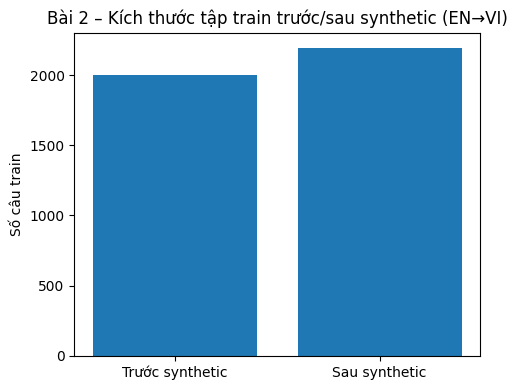

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

before_train = 2000   # số dòng train gốc thực tế
syn_add      = 192    # số synthetic
after_train  = before_train + syn_add

plt.figure(figsize=(5,4))
plt.bar(["Trước synthetic", "Sau synthetic"], [before_train, after_train])
plt.ylabel("Số câu train")
plt.title("Bài 2 – Kích thước tập train trước/sau synthetic (EN→VI)")
plt.tight_layout()
plt.show()

## 🏋️ TRAINING – Huấn luyện


### Cấu hình huấn luyện & BLEU metric

- Dùng sacreBLEU làm thước đo chính
- Seq2SeqTrainingArguments cho MarianMT


In [ ]:
import numpy as np
import evaluate
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

metric_bleu = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    # sacrebleu yêu cầu mỗi câu refs là list[list[str]]
    labels = [[l.strip()] for l in labels]
    return preds, labels

def compute_metrics_en_vi(eval_pred):
    preds, labels = eval_pred

    # decode predictions
    decoded_preds = tok_en_vi.batch_decode(preds, skip_special_tokens=True)

    # replace -100 trong labels thành pad token id rồi decode
    labels = np.where(labels != -100, labels, tok_en_vi.pad_token_id)
    decoded_labels = tok_en_vi.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric_bleu.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": round(result["score"], 2)}

fp16 = torch.cuda.is_available()

args_en_vi = Seq2SeqTrainingArguments(
    output_dir=f"{base_dir}/mt_en_vi",
    num_train_epochs=1,                  # demo 1 epoch, có thể tăng 2–3
    per_device_train_batch_size=4,       # nhỏ để tránh OOM
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,       # batch effective = 16
    eval_accumulation_steps=4,

    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.06,

    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,

    predict_with_generate=True,
    fp16=fp16,
    report_to="none",
)

trainer_en_vi = Seq2SeqTrainer(
    model=model_en_vi,
    args=args_en_vi,
    train_dataset=encoded_en_vi["train"],
    eval_dataset=encoded_en_vi["validation"],
    tokenizer=tok_en_vi,
    data_collator=data_collator_en_vi,
    compute_metrics=compute_metrics_en_vi,
)

/tmp/ipython-input-1592672584.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_en_vi = Seq2SeqTrainer(


### Huấn luyện + đánh giá nhanh EN→VI


In [ ]:
train_out_en_vi = trainer_en_vi.train()
print(train_out_en_vi)

test_metrics_en_vi = trainer_en_vi.evaluate(encoded_en_vi["test"])
print("Test EN→VI BLEU:", test_metrics_en_vi)

# Lưu model đã fine-tune
trainer_en_vi.save_model(f"{base_dir}/models/mt_en_vi_marian")
tok_en_vi.save_pretrained(f"{base_dir}/models/mt_en_vi_marian")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Bleu
1,0.147000,0.156319,25.460000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[53684]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=1250, training_loss=0.21891258926391602, metrics={'train_runtime': 376.5021, 'train_samples_per_second': 53.121, 'train_steps_per_second': 3.32, 'total_flos': 677967298560000.0, 'train_loss': 0.21891258926391602, 'epoch': 1.0})


Test EN→VI BLEU: {'eval_loss': 0.1622852236032486, 'eval_bleu': 25.9, 'eval_runtime': 74.3228, 'eval_samples_per_second': 13.455, 'eval_steps_per_second': 3.364, 'epoch': 1.0}


('/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian/tokenizer_config.json',
 '/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian/special_tokens_map.json',
 '/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian/vocab.json',
 '/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian/source.spm',
 '/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian/target.spm',
 '/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian/added_tokens.json')

### Huấn luyện chiều VI→EN


In [ ]:
def compute_metrics_vi_en(eval_pred):
    preds, labels = eval_pred

    decoded_preds = tok_vi_en.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tok_vi_en.pad_token_id)
    decoded_labels = tok_vi_en.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric_bleu.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": round(result["score"], 2)}

args_vi_en = Seq2SeqTrainingArguments(
    output_dir=f"{base_dir}/mt_vi_en",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    eval_accumulation_steps=4,

    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.06,

    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,

    predict_with_generate=True,
    fp16=fp16,
    report_to="none",
)

trainer_vi_en = Seq2SeqTrainer(
    model=model_vi_en,
    args=args_vi_en,
    train_dataset=encoded_vi_en["train"],
    eval_dataset=encoded_vi_en["validation"],
    tokenizer=tok_vi_en,
    data_collator=data_collator_vi_en,
    compute_metrics=compute_metrics_vi_en,
)

/tmp/ipython-input-2902936145.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_vi_en = Seq2SeqTrainer(


### Huấn luyện + đánh giá nhanh VI→EN


In [ ]:
train_out_vi_en = trainer_vi_en.train()
print(train_out_vi_en)

test_metrics_vi_en = trainer_vi_en.evaluate(encoded_vi_en["test"])
print("Test VI→EN BLEU:", test_metrics_vi_en)

trainer_vi_en.save_model(f"{base_dir}/models/mt_vi_en_marian")
tok_vi_en.save_pretrained(f"{base_dir}/models/mt_vi_en_marian")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Bleu
1,0.130200,0.164173,26.520000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[53738]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=1250, training_loss=0.32004386100769044, metrics={'train_runtime': 371.9629, 'train_samples_per_second': 53.769, 'train_steps_per_second': 3.361, 'total_flos': 677967298560000.0, 'train_loss': 0.32004386100769044, 'epoch': 1.0})


Test VI→EN BLEU: {'eval_loss': 0.16107416152954102, 'eval_bleu': 28.94, 'eval_runtime': 74.6776, 'eval_samples_per_second': 13.391, 'eval_steps_per_second': 3.348, 'epoch': 1.0}


('/content/drive/MyDrive/nlp_final/models/mt_vi_en_marian/tokenizer_config.json',
 '/content/drive/MyDrive/nlp_final/models/mt_vi_en_marian/special_tokens_map.json',
 '/content/drive/MyDrive/nlp_final/models/mt_vi_en_marian/vocab.json',
 '/content/drive/MyDrive/nlp_final/models/mt_vi_en_marian/source.spm',
 '/content/drive/MyDrive/nlp_final/models/mt_vi_en_marian/target.spm',
 '/content/drive/MyDrive/nlp_final/models/mt_vi_en_marian/added_tokens.json')

### Fine-tune Marian EN→VI với tập train đã augment (có synthetic)


In [ ]:
# ========== CELL 2: TRAIN MARIAN EN→VI + SYNTHETIC (FIX FOR TRANSFORMERS 4.44+) ==========
from transformers import DataCollatorForSeq2Seq, Trainer, TrainingArguments

# Tokenization
def preprocess_mt(batch):
    en_list = [ex["en"] for ex in batch["translation"]]
    vi_list = [ex["vi"] for ex in batch["translation"]]

    model_inputs = tok_en_vi(
        en_list,
        padding="max_length",
        truncation=True,
        max_length=128
    )

    # TOKENIZE TARGET PROPER WAY (không dùng as_target_tokenizer nữa)
    labels = tok_en_vi(
        text_target=vi_list,
        padding="max_length",
        truncation=True,
        max_length=128
    )
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


encoded_train_aug = mt_ds_aug["train"].map(preprocess_mt, batched=True)
encoded_val       = mt_ds_aug["validation"].map(preprocess_mt, batched=True)

data_collator = DataCollatorForSeq2Seq(tok_en_vi, model=model_en_vi)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/nlp_final/marian_en_vi_synthetic",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=1,
    eval_strategy="epoch",      # <-- THAY evaluation_strategy
    save_strategy="epoch",      # <-- SAFE
    logging_steps=50,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model_en_vi,
    args=training_args,
    train_dataset=encoded_train_aug,
    eval_dataset=encoded_val,
    tokenizer=tok_en_vi,
    data_collator=data_collator
)

print("🚀 BẮT ĐẦU HUẤN LUYỆN MARIAN EN→VI — SYNTHETIC")
trainer.train()
print("🎉 TRAIN HOÀN TẤT")


Map:   0%|          | 0/2192 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipython-input-830106481.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


🚀 BẮT ĐẦU HUẤN LUYỆN MARIAN EN→VI — SYNTHETIC


Epoch,Training Loss,Validation Loss
1,0.125100,0.167045


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[53684]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


🎉 TRAIN HOÀN TẤT


## 🔍 TEST & ĐÁNH GIÁ


### BLEU baseline (trước synthetic – Marian pretrained)


In [ ]:
import evaluate
import numpy as np
import torch

# Load lại model Marian pretrained (không fine-tune)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tok_pre = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-vi")
model_pre = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-vi").to("cuda")

bleu_metric = evaluate.load("sacrebleu")

preds = []
refs = []

print("Đang tính BLEU trước synthetic...")

for ex in ds["test"]:
    src = ex["translation"]["en"]
    ref = ex["translation"]["vi"]

    inputs = tok_pre(src, return_tensors="pt", truncation=True).to("cuda")
    output = model_pre.generate(**inputs, max_new_tokens=128)

    pred = tok_pre.decode(output[0], skip_special_tokens=True)

    preds.append(pred)
    refs.append([ref])  # sacrebleu yêu cầu dạng list[list]

result = bleu_metric.compute(predictions=preds, references=refs)
print("BLEU trước synthetic:", result)


Đang tính BLEU trước synthetic...
BLEU trước synthetic: {'score': 22.501969519840358, 'counts': [5349, 2669, 1494, 854], 'totals': [10745, 9745, 8746, 7758], 'precisions': [49.78129362494183, 27.388404309902516, 17.082094671849987, 11.007991750451147], 'bp': 1.0, 'sys_len': 10745, 'ref_len': 10460}


### BLEU EN→VI sau khi fine-tune + synthetic (và ví dụ dịch)

In [ ]:
# ========== CELL 3: EVALUATE BLEU SAU TRAIN (FIX CHO DATASETS MỚI) ==========

import evaluate
import numpy as np
import torch

bleu_metric = evaluate.load("sacrebleu")

# Hàm lấy song ngữ từ dataset
def get_parallel(split, src_lang="en", tgt_lang="vi", max_samples=None):
    src_texts = []
    tgt_texts = []
    for ex in split["translation"]:
        src_texts.append(ex[src_lang])
        tgt_texts.append([ex[tgt_lang]])  # sacrebleu yêu cầu list of list
        if max_samples is not None and len(src_texts) >= max_samples:
            break
    return src_texts, tgt_texts


# 1) Lấy test EN→VI
src_en, refs_vi = get_parallel(mt_ds_aug["test"], src_lang="en", tgt_lang="vi")

print(f"🔢 Số câu test: {len(src_en)}")

# 2) Predict bằng model đã fine-tune
batch_size = 16
preds_vi = []

model_en_vi.eval()
for i in range(0, len(src_en), batch_size):
    batch_src = src_en[i:i+batch_size]
    batch = tok_en_vi(
        batch_src,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(model_en_vi.device)

    with torch.no_grad():
        gen_ids = model_en_vi.generate(**batch, max_new_tokens=128)

    batch_preds = tok_en_vi.batch_decode(gen_ids, skip_special_tokens=True)
    preds_vi.extend(batch_preds)

# 3) Tính BLEU
bleu_res = bleu_metric.compute(predictions=preds_vi, references=refs_vi)

print("📌 BLEU sau khi fine-tune + synthetic:")
print(bleu_res)

# 4) In ví dụ
print("\n================= VÍ DỤ DỊCH EN→VI =================\n")
for i in range(5):
    print(f"🔹 Source:    {src_en[i]}")
    print(f"🔸 Reference: {refs_vi[i][0]}")
    print(f"✅ Predict:   {preds_vi[i]}")
    print("---")

🔢 Số câu test: 500
📌 BLEU sau khi fine-tune + synthetic:
{'score': 23.911257779805172, 'counts': [2675, 1370, 789, 456], 'totals': [5264, 4764, 4264, 3772], 'precisions': [50.816869300911854, 28.757346767422334, 18.50375234521576, 12.089077412513255], 'bp': 1.0, 'sys_len': 5264, 'ref_len': 5145}

================= VÍ DỤ DỊCH EN→VI =================

🔹 Source:    She says it's her piano and she won't have him touch it!
🔸 Reference: Mẹ nói đó là đàn của Mẹ và Mẹ không muốn ông ấy đụng vô!
✅ Predict:   Cô ấy nói đó là đàn piano của cô ấy và cô ấy sẽ không để hắn chạm vào nó!
---
🔹 Source:    The workout this morning will be slightly different .
🔸 Reference: Buổi tập sáng nay sẽ hơi khác một chút.
✅ Predict:   Buổi tập sáng nay sẽ hơi khác một chút.
---
🔹 Source:    - I thought you needed some. - It was nice of you.
🔸 Reference: Em thật tử tế
✅ Predict:   - Tôi nghĩ anh cần một ít.
---
🔹 Source:    Third Uncle, we would like to go into the courtyard and talk privately.
🔸 Reference: Chú Ba,

### So sánh BLEU EN→VI trước & sau synthetic (biểu đồ)


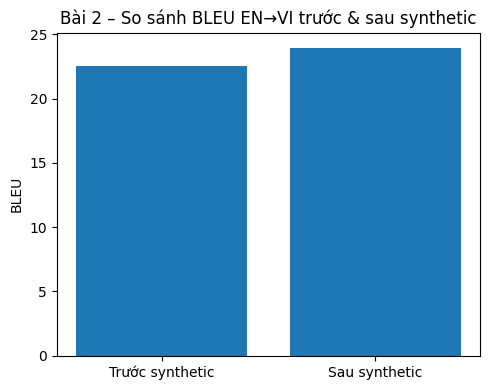

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bleu_before = 22.501969519840358
bleu_after  = 23.911257779805172

plt.figure(figsize=(5,4))
plt.bar(["Trước synthetic", "Sau synthetic"], [bleu_before, bleu_after])
plt.ylabel("BLEU")
plt.title("Bài 2 – So sánh BLEU EN→VI trước & sau synthetic")
plt.tight_layout()
plt.show()

### Ví dụ dịch thử EN→VI


In [ ]:
def translate_en_vi(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]
    enc = tok_en_vi.prepare_seq2seq_batch(
        src_texts=sentences,
        return_tensors="pt",
        max_length=max_source_length,
        truncation=True,
    ).to(device)
    with torch.no_grad():
        gen_ids = model_en_vi.generate(**enc, max_new_tokens=64, num_beams=4)
    return tok_en_vi.batch_decode(gen_ids, skip_special_tokens=True)

samples = [
    "This product is very good and I really like it.",
    "The weather today is terrible, it has been raining all day.",
]
print(translate_en_vi(samples))

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4156: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


['sản phẩm này rất tốt và tôi thực sự thích nó.', 'Thời tiết hôm nay thật kinh khủng, trời mưa cả ngày.']


### Ví dụ dịch thử VI→EN


In [ ]:
def translate_vi_en(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]
    enc = tok_vi_en.prepare_seq2seq_batch(
        src_texts=sentences,
        return_tensors="pt",
        max_length=max_source_length,
        truncation=True,
    ).to(device)
    with torch.no_grad():
        gen_ids = model_vi_en.generate(**enc, max_new_tokens=64, num_beams=4)
    return tok_vi_en.batch_decode(gen_ids, skip_special_tokens=True)

samples_vi = [
    "Hôm nay trời mưa cả ngày nên mình không muốn ra ngoài.",
    "Sản phẩm này có chất lượng rất tốt và mình cực kỳ hài lòng.",
]
print(translate_vi_en(samples_vi))

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4156: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


["It's raining all day, so I don't want to go out.", "This product is very good and I'm extremely happy."]


### Load model cuối để inference


In [ ]:
import torch
from transformers import MarianMTModel, MarianTokenizer

base_dir = "/content/drive/MyDrive/nlp_final"  # sửa nếu bạn dùng path khác
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ===== EN → VI =====
path_en_vi = f"{base_dir}/models/mt_en_vi_marian"

model_en_vi = MarianMTModel.from_pretrained(path_en_vi).to(device)
tok_en_vi   = MarianTokenizer.from_pretrained(path_en_vi)
model_en_vi.eval()

# ===== VI → EN =====
path_vi_en = f"{base_dir}/models/mt_vi_en_marian"

model_vi_en = MarianMTModel.from_pretrained(path_vi_en).to(device)
tok_vi_en   = MarianTokenizer.from_pretrained(path_vi_en)
model_vi_en.eval()

print("Đã load xong 2 mô hình dịch EN↔VI từ Drive ✅")

Device: cuda
Đã load xong 2 mô hình dịch EN↔VI từ Drive ✅


### Hàm inference cho EN↔VI


In [ ]:
def translate_en_vi(sentences, max_new_tokens=64):
    """Dịch từ tiếng Anh sang tiếng Việt (EN→VI)."""
    if isinstance(sentences, str):
        sentences = [sentences]
    batch = tok_en_vi(
        sentences,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    ).to(device)
    with torch.no_grad():
        gen = model_en_vi.generate(
            **batch,
            max_new_tokens=max_new_tokens,
            num_beams=4,
        )
    return tok_en_vi.batch_decode(gen, skip_special_tokens=True)


def translate_vi_en(sentences, max_new_tokens=64):
    """Dịch từ tiếng Việt sang tiếng Anh (VI→EN)."""
    if isinstance(sentences, str):
        sentences = [sentences]
    batch = tok_vi_en(
        sentences,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    ).to(device)
    with torch.no_grad():
        gen = model_vi_en.generate(
            **batch,
            max_new_tokens=max_new_tokens,
            num_beams=4,
        )
    return tok_vi_en.batch_decode(gen, skip_special_tokens=True)

### Demo dịch thử EN↔VI sau fine-tune


In [ ]:
# EN → VI
src_en = [
    "This product is really good and I am very satisfied with it.",
    "The service was slow and I had to wait for a long time.",
    "How are you today?",
]
vi_trans = translate_en_vi(src_en)
for s, t in zip(src_en, vi_trans):
    print("EN :", s)
    print("VI :", t)
    print("-" * 50)

# VI → EN
src_vi = [
    "Chất lượng đồ ăn ở đây rất tốt, mình sẽ quay lại lần sau.",
    "Dịch vụ quá chậm, mình phải chờ gần một tiếng đồng hồ.",
    "Tôi cảm thấy không khỏe",
]
en_trans = translate_vi_en(src_vi)
for s, t in zip(src_vi, en_trans):
    print("VI :", s)
    print("EN :", t)
    print("-" * 50)

EN : This product is really good and I am very satisfied with it.
VI : sản phẩm này thực sự tốt và tôi rất hài lòng với nó.
--------------------------------------------------
EN : The service was slow and I had to wait for a long time.
VI : Công việc rất chậm và tôi phải chờ đợi rất lâu.
--------------------------------------------------
EN : How are you today?
VI : Hôm nay anh thế nào?
--------------------------------------------------
VI : Chất lượng đồ ăn ở đây rất tốt, mình sẽ quay lại lần sau.
EN : The quality of food here is good, I'll come back next time.
--------------------------------------------------
VI : Dịch vụ quá chậm, mình phải chờ gần một tiếng đồng hồ.
EN : The service's too slow, we have to wait for almost an hour.
--------------------------------------------------
VI : Tôi cảm thấy không khỏe
EN : I don't feel well.
--------------------------------------------------


### Load model EN↔VI sau khi fine-tune


In [ ]:
# EN → VI
model_en_vi_dir = f"{base_dir}/models/mt_en_vi_marian"
tok_en_vi = MarianTokenizer.from_pretrained(model_en_vi_dir)
model_en_vi = MarianMTModel.from_pretrained(model_en_vi_dir).to(device)
model_en_vi.eval()

# VI → EN
model_vi_en_dir = f"{base_dir}/models/mt_vi_en_marian"
tok_vi_en = MarianTokenizer.from_pretrained(model_vi_en_dir)
model_vi_en = MarianMTModel.from_pretrained(model_vi_en_dir).to(device)
model_vi_en.eval()

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(53739, 512, padding_idx=53738)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(53739, 512, padding_idx=53738)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

### Tạo tập con để đánh giá nhanh (subset)


In [ ]:
from datasets import load_dataset, DatasetDict
import evaluate
import numpy as np

# chỉ load 1 ít cho nhẹ
ds = load_dataset("opus100", "en-vi")

SEED = 42
train_small = ds["train"].shuffle(SEED).select(range(2000))
valid_small = ds["validation"].shuffle(SEED+1).select(range(500))
test_small  = ds["test"].shuffle(SEED+2).select(range(500))

mt_ds = DatasetDict({
    "train": train_small,
    "validation": valid_small,
    "test": test_small,
})

print(mt_ds)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 500
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 500
    })
})


### Load lại dataset & model để đánh giá cuối


In [ ]:
import torch
from datasets import load_dataset
from transformers import MarianMTModel, MarianTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# base_dir bạn đang dùng cho cả project
base_dir = "/content/drive/MyDrive/nlp_final"

# 1) Load lại song ngữ EN↔VI từ opus100
mt_ds = load_dataset("opus100", "en-vi")
print(mt_ds)

# 2) Load lại model đã fine-tune (đã lưu từ trước)
model_en_vi = MarianMTModel.from_pretrained(f"{base_dir}/models/mt_en_vi_marian").to(device)
tok_en_vi   = MarianTokenizer.from_pretrained(f"{base_dir}/models/mt_en_vi_marian")

model_vi_en = MarianMTModel.from_pretrained(f"{base_dir}/models/mt_vi_en_marian").to(device)
tok_vi_en   = MarianTokenizer.from_pretrained(f"{base_dir}/models/mt_vi_en_marian")

model_en_vi.eval()
model_vi_en.eval()


Device: cuda
DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(53739, 512, padding_idx=53738)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(53739, 512, padding_idx=53738)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

### Chuẩn bị tập song ngữ để tính BLEU


In [ ]:
from typing import List, Tuple

def get_parallel(split, src_lang: str, tgt_lang: str, max_samples: int = 200) -> Tuple[List[str], List[List[str]]]:
    """
    split: mt_ds["test"] / ["train"] / ["validation"]
    src_lang: "en" hoặc "vi"
    tgt_lang: "vi" hoặc "en"
    return:
      - src:  [str, ...]
      - refs: [[str], [str], ...]  # sacrebleu cần list of list
    """
    trans = split["translation"]
    if max_samples is not None:
        trans = trans[:max_samples]

    src  = [ex[src_lang] for ex in trans]
    refs = [[ex[tgt_lang]] for ex in trans]  # mỗi câu 1 reference

    return src, refs

### Tính BLEU thủ công EN→VI (sacreBLEU)


In [ ]:
import evaluate
bleu_metric = evaluate.load("sacrebleu")

def eval_bleu_en_vi(split, max_samples=200):
    # 1) Lấy cặp EN→VI
    src, refs = get_parallel(split, src_lang="en", tgt_lang="vi", max_samples=max_samples)

    # 2) Tokenize & generate
    batch = tok_en_vi(src, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        gen_ids = model_en_vi.generate(**batch, max_new_tokens=128)
    preds = tok_en_vi.batch_decode(gen_ids, skip_special_tokens=True)

    # 3) Tính BLEU
    res = bleu_metric.compute(predictions=preds, references=refs)
    return res, list(zip(src[:10], [r[0] for r in refs[:10]], preds[:10]))  # trả 10 ví dụ

bleu_en_vi, samples_en_vi = eval_bleu_en_vi(mt_ds["test"], max_samples=200)
print("EN→VI BLEU:", bleu_en_vi)

EN→VI BLEU: {'score': 28.097281748837144, 'counts': [1147, 639, 396, 243], 'totals': [2146, 1946, 1746, 1552], 'precisions': [53.44827586206897, 32.83658787255909, 22.68041237113402, 15.657216494845361], 'bp': 1.0, 'sys_len': 2146, 'ref_len': 2052}


### Tính BLEU thủ công VI→EN (sacreBLEU)


In [ ]:
def eval_bleu_vi_en(split, max_samples=200):
    # 1) Lấy cặp VI→EN
    src, refs = get_parallel(split, src_lang="vi", tgt_lang="en", max_samples=max_samples)

    batch = tok_vi_en(src, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        gen_ids = model_vi_en.generate(**batch, max_new_tokens=128)
    preds = tok_vi_en.batch_decode(gen_ids, skip_special_tokens=True)

    res = bleu_metric.compute(predictions=preds, references=refs)
    return res, list(zip(src[:10], [r[0] for r in refs[:10]], preds[:10]))

bleu_vi_en, samples_vi_en = eval_bleu_vi_en(mt_ds["test"], max_samples=200)
print("VI→EN BLEU:", bleu_vi_en)

VI→EN BLEU: {'score': 27.963500623349923, 'counts': [993, 549, 320, 190], 'totals': [1696, 1496, 1296, 1104], 'precisions': [58.549528301886795, 36.69786096256684, 24.691358024691358, 17.21014492753623], 'bp': 0.9046240381482478, 'sys_len': 1696, 'ref_len': 1866}


## 🤖 LLM-based Evaluation

### Prompt đánh giá bằng LLM

Bạn là chuyên gia NLP.

Nhiệm vụ:
Đánh giá chất lượng mô hình dịch EN→VI (MarianMT sau khi fine-tune + synthetic).

Bạn được cung cấp các mẫu gồm:
- src: câu nguồn (tiếng Anh)
- ref: bản dịch tham chiếu (tiếng Việt)
- pred: bản dịch của mô hình (tiếng Việt)

Hãy chấm mỗi mẫu theo thang điểm 1–5 cho:

1. Adequacy (đầy đủ ý nghĩa gốc)
2. Fluency (tự nhiên, đúng ngữ pháp)
3. Meaning Preservation (giữ đúng nội dung)
4. Appropriateness (từ vựng phù hợp ngữ cảnh, xưng hô hợp lý)

Với mỗi mẫu:
- Chấm điểm 4 tiêu chí
- Nhận xét ngắn (1–2 câu)
- Gợi ý sửa câu dịch nếu cần

Output mong muốn:
1) Bảng điểm cho từng mẫu
2) Điểm trung bình cho mỗi tiêu chí
3) Nhận xét tổng kết


**Điểm trung bình (5 mẫu EN→VI, sau synthetic):**

- Adequacy: ~4.0 / 5  
- Fluency: ~4.0 / 5  
- Meaning Preservation: ~4.0 / 5  
- Appropriateness: ~3.6 / 5  


### Nhận xét tổng kết (LLM-based Evaluation – EN→VI)

Qua 5 mẫu được LLM đánh giá, mô hình MarianMT EN→VI sau khi fine-tune (có bổ sung synthetic) nhìn chung:

- Dịch **đúng ý và đầy đủ nội dung** đối với đa số câu (Adequacy & Meaning ≈ 4.0).
- Câu dịch khá **trôi chảy, tự nhiên**, ít lỗi ngữ pháp rõ rệt (Fluency ≈ 4.0).
- Một số lỗi xuất hiện ở các câu hội thoại phức tạp:
  - Bỏ sót mệnh đề (“It was nice of you” không được dịch).
  - Dịch sai hoặc không tự nhiên ở phần xưng hô / danh xưng (“Third Uncle” → “Thứ ba”).

Nhìn chung, mô hình phù hợp cho các câu mô tả, câu tin tức và câu thông tin chung.  
Tuy nhiên, với các đoạn hội thoại, xưng hô, sắc thái ngữ dụng, mô hình vẫn cần được cải thiện thêm (ví dụ: bổ sung dữ liệu hội thoại hoặc tinh chỉnh prompt/decoding).  

Lưu ý: LLM-eval ở đây chỉ thực hiện cho chiều **EN→VI sau fine-tune + synthetic**; chiều VI→EN không áp dụng synthetic và chỉ được đánh giá bằng BLEU.


### LOAD MODEL

In [ ]:
# ==== LOAD MODEL MARIAN MT EN → VI ====

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/drive/MyDrive/nlp_final/models/mt_en_vi_marian"

tok_en_vi = AutoTokenizer.from_pretrained(model_path)
model_en_vi = AutoModelForSeq2SeqLM.from_pretrained(model_path)

print("MarianMT đã load thành công!")


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMT đã load thành công!


In [ ]:
def translate_en_vi(text):
    encoded = tok_en_vi([text], return_tensors="pt")
    output = model_en_vi.generate(
        **encoded,
        max_length=80,
        num_beams=4
    )
    return tok_en_vi.decode(output[0], skip_special_tokens=True)

print(translate_en_vi("I'm hungry."))

Tôi đói quá.
